This document is to explore building an LSTM deep learning model on the obtained data set.

In [14]:
import MetaTrader5 as mt5
from datetime import datetime
import pytz
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt    
import math

In [48]:
#build connection
mt5.initialize(
    path = "C:\\Users\\silin\\AppData\\Roaming\\MetaTrader 5\\terminal64.exe",
    login = 35146240,
    password = "xt7lixru"
    )

# query data
timezone = pytz.timezone("Etc/UTC")
utc_from = datetime(2020, 1, 1, tzinfo=timezone)

rates = mt5.copy_rates_from('EURUSD', mt5.TIMEFRAME_H1, utc_from, 20000)

#off connection
mt5.shutdown()

# cleanup data
eurusd = pd.DataFrame(rates)
eurusd['time']=pd.to_datetime(eurusd['time'], unit='s')
#rates_frame.to_csv("EURUSD_200923_190425.csv")

Below is the code to generate LSTM model. Keras and Tensorflow is used here.    
- Data preprocessing:   
    1. normalization (sklearn.preprocessing.MinMaxScaler)   
    2. split train/test Data   
    3. prepare target column [$Y_{t}=f(X_{t-1},...)$]   
    4. reshape to numpy array: In keras sequential model, the input shape = (samples, step, feature)

- Model setup:
    1. in this model shown, 1st layer is an LSTM layer with 64 hidden units. input shape is (batch, step, feature) and output shape is (batch, 64)   
    2. 2nd layer is dense layer, reduce shape to (batch,16)   
    3. 3rd layer is a linear dense, output the result shape (batch, 1)

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [55]:
# fix random seed for reproducibility
np.random.seed(7)

dataset = eurusd.loc[:,['close']].values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



16000 4000


In [57]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="linear"))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0260
Epoch 2/100
 - 1s - loss: 3.2092e-05
Epoch 3/100
 - 1s - loss: 3.0932e-05
Epoch 4/100
 - 1s - loss: 3.0405e-05
Epoch 5/100
 - 1s - loss: 2.9345e-05
Epoch 6/100
 - 1s - loss: 2.9576e-05
Epoch 7/100
 - 1s - loss: 2.8674e-05
Epoch 8/100
 - 1s - loss: 2.7601e-05
Epoch 9/100
 - 1s - loss: 2.7102e-05
Epoch 10/100
 - 1s - loss: 2.6579e-05
Epoch 11/100
 - 1s - loss: 2.7221e-05
Epoch 12/100
 - 1s - loss: 2.6535e-05
Epoch 13/100
 - 1s - loss: 2.6241e-05
Epoch 14/100
 - 1s - loss: 2.6781e-05
Epoch 15/100
 - 1s - loss: 2.7729e-05
Epoch 16/100
 - 1s - loss: 2.8380e-05
Epoch 17/100
 - 1s - loss: 2.7712e-05
Epoch 18/100
 - 1s - loss: 2.7649e-05
Epoch 19/100
 - 1s - loss: 2.7715e-05
Epoch 20/100
 - 1s - loss: 2.7981e-05
Epoch 21/100
 - 1s - loss: 2.8192e-05
Epoch 22/100
 - 1s - loss: 2.9347e-05
Epoch 23/100
 - 1s - loss: 2.8070e-05
Epoch 24/100
 - 1s - loss: 2.7278e-05
Epoch 25/100
 - 1s - loss: 2.9475e-05
Epoch 26/100
 - 1s - loss: 2.7629e-05
Epoch 27/100
 - 1s - loss

After model training, below will be the model predictions. We will predict trainX and testX separately and compare with trainY and testY.   

Since we use the MinMaxScaler, the output from the model will also be a scaled value between 0 and 1. We need the `scaler.inverse_transform()` to map back to the actual value.

The common evaluation metric is RMSE/MAE. Since our data is very small close to 1, MAE will be better choice.  

In [58]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

Train Score: 0.00 MAE
Test Score: 0.00 MAE


Another view of the prediction result is plot the prediction vs actual. Below is the sample code for draw a line plot.

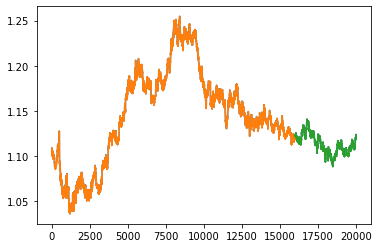

In [59]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()